In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from auxiliary import plot_cm, plot_nn_metrics, plot_roc, save_metrics, drop_var_nonobj, drop_var_obj, plot_pr_curve, plot_elbow_kmeans, grids_skf_lsvc, grids_skf_rf, grids_skf_svc, grids_skf_xgb, grids_skf_lr

import os
import tempfile

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
#Change path according to directory used
#w_path = r'C:\Users\henri\OneDrive\Documentos\EDSA\EDS Bootcamp\Project'
dataset_path = '../Data/HR_DS.csv'
df = pd.read_csv(dataset_path)

In [3]:
# Remove non object variables with no variability
drop_var_nonobj(df)

2 columns, ['EmployeeCount', 'StandardHours'] were droped


In [4]:
# Remove object variables with no variability
drop_var_obj(df)

The ['Over18'] column was droped.


In [5]:
objects = df.describe(include='O').columns.tolist()
non_objs = df.describe().columns.tolist()

patterns = [' ', 'Travel_', '-', '&']

for p in patterns:
    df[objects] = df[objects].apply(lambda x: x.str.replace(p, ''))
    print('Pattern "{}" cleared.'.format(p))

Pattern " " cleared.
Pattern "Travel_" cleared.
Pattern "-" cleared.
Pattern "&" cleared.


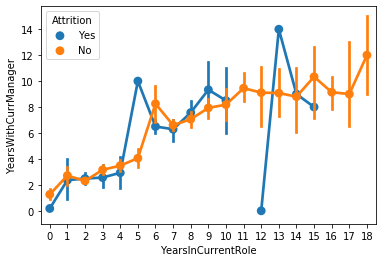

In [6]:
sb.pointplot(df.YearsInCurrentRole, df.YearsWithCurrManager, hue=df.Attrition)
plt.show()

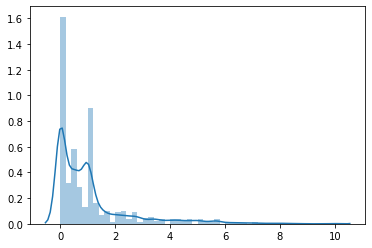

In [7]:
sb.distplot((df.TotalWorkingYears-df.YearsAtCompany)/(df.NumCompaniesWorked+1))
plt.show()

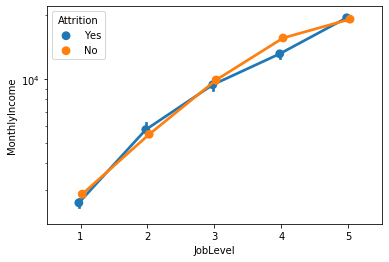

In [8]:
sb.pointplot(df.JobLevel, df.MonthlyIncome, hue=df.Attrition, dodge=True)
plt.yscale('log')
plt.show()

In [9]:
# Score that evaluates the number of years per companies
# The lower the score, the less stable/unexperienced the employee is
# The higher the score, the most stable/experienced the employee it
df['StayScore']=((df.TotalWorkingYears-df.YearsAtCompany)/(df.NumCompaniesWorked+1))

In [10]:
df.StayScore.describe()

count    1470.000000
mean        1.035314
std         1.430512
min         0.000000
25%         0.000000
50%         0.600000
75%         1.000000
max        10.000000
Name: StayScore, dtype: float64

In [11]:
df.drop(columns=['JobLevel', 'EmployeeNumber', 'TotalWorkingYears', 'NumCompaniesWorked', 'YearsAtCompany'], inplace=True)

In [12]:
objects = df.describe(include='O').columns.tolist()
non_objs = df.describe().columns.tolist()

Making some dummies

In [13]:
finaldf = pd.get_dummies(df, drop_first=True)

In [14]:
n_features = len(finaldf.columns)
n_features

42

# Models Testing (Train, Test split)
First, the dataset has to be split into 2 sets of data so that the following is available for every model:
* A train dataset (features and labels appart) (90%)
* A test dataset (features and labels appart) (10%)
    * Will be used to test the final models as an out-of-sample dataset.
    
Further on, the models will be evaluated on using Stratified K Fold Testing (5 folds again on the training dataset)

In [15]:
from IPython.core.display import display, HTML
display(HTML('../resources/modeling.html'))

In [16]:
# test 10%; train 90%
train_df, test_df = train_test_split(finaldf, test_size=0.1, random_state=0, stratify=finaldf.Attrition_Yes)

# Initialization of min-max normalizing scaler
minmax = MinMaxScaler()

# Form np arrays of labels and features
train_labels = np.array(train_df.Attrition_Yes)
#bool_train_labels = train_labels != 0
test_labels = np.array(test_df.Attrition_Yes)

# The train and test features will be normalized separatedly in order not to cross-contaminate data
train_features = train_df.drop('Attrition_Yes', axis=1)
test_features = minmax.fit_transform(test_df.drop('Attrition_Yes', axis=1))

print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('')
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (1323,)
Test labels shape: (147,)

Training features shape: (1323, 41)
Test features shape: (147, 41)


A check on the imbalance of the datasets is needed

In [17]:
neg_df, pos_df = np.bincount(finaldf.Attrition_Yes)
total_df = neg_df + pos_df
neg_test, pos_test = np.bincount(test_labels)
total_test = neg_test + pos_test
neg_t, pos_t = np.bincount(train_labels)
total_t = neg_t + pos_t

print('Cases on full dataset:\n\tTotal: {}\n\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_df, pos_df, 100 * pos_df / total_df))
print('\tCases on test dataset:\n\t\tTotal: {}\n\t\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_test, pos_test, 100 * pos_test / total_test))
print('\tCases on training dataset:\n\t\tTotal: {}\n\t\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_t, pos_t, 100 * pos_t / total_t))

Cases on full dataset:
	Total: 1470
	Employees that Left the company: 237 (16.12% of total)

	Cases on test dataset:
		Total: 147
		Employees that Left the company: 24 (16.33% of total)

	Cases on training dataset:
		Total: 1323
		Employees that Left the company: 213 (16.10% of total)



A determination of the weights of the target label (train dataset) will be important further on the testing of the models

In [18]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg_t)*(total_t)/2
weight_for_1 = (1 / pos_t)*(total_t)/2

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (Stayers): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Leavers): {:.2f}'.format(weight_for_1))

Weight for class 0 (Stayers): 0.60
Weight for class 1 (Leavers): 3.11


In [19]:
# initialization of the dataframe to store the metrics for each model evaluated on test split
m_summary = pd.DataFrame(columns=[
    'model','tp', 'fp', 'tn', 'fn', 
    'acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef', 
    'batch_s', 'data', 'series'
])

In [20]:
# standart number of folds to be used by StratifiedKfold sampling
n_folds = 5

## 1. XGBoost

### GridSearch with Stratified K-Fold CV

In [21]:
# fit model on training data
parameters_XGB = {
    'objective':['binary:logistic'],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [i for i in range(5,10)],
    'subsample': [0.5, 1],
    'colsample_bytree': [0.5, 1],
    'n_estimators': [100, 1000],
    'seed': [123]}

model_XGB = grids_skf_xgb(
    train_features,
    train_labels, 
    parameters_XGB, 
    pos_t/neg_t, 
    n_folds
)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1918918918918919,
              seed=123, silent=None, subsample=1, verbosity=0)


In [22]:
#m_summary = save_metrics(m_summary, 'model_XGB', test_labels, model_XGB.predict_proba(test_features)[:, 1], split_data='test')

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

minmax = MinMaxScaler()
train_feat_norm = minmax.fit_transform(train_features)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_XGB.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_XGB', ytrain, model_XGB.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_XGB', yval, model_XGB.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_XGB', test_labels, model_XGB.predict_proba(test_features)[:, 1], split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


In [23]:
m_summary.groupby(['model', 'data']).mean()

acc      prec    recall    pr_auc        f1   mc_coef  \
model     data                                                                
model_XGB test   0.848980  0.733333  0.133333  0.432507  0.223492  0.265330   
          train  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
          val    0.873013  0.813333  0.281728  0.555749  0.415212  0.428283   

                 batch_s  
model     data            
model_XGB test       NaN  
          train      NaN  
          val        NaN

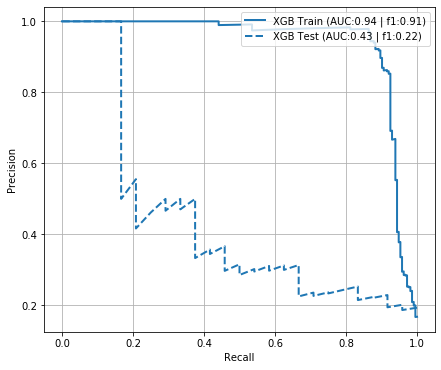

Stayers Detected (True Negatives):  123
Stayers Missed (False Positives):  0
Leavers Missed (False Negatives):  21
Leavers Detected (True Positives):  3


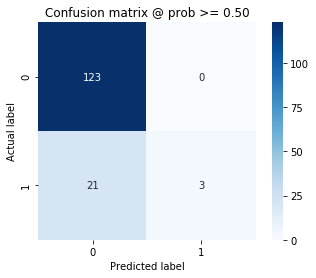

In [24]:
plt.figure(figsize=(7, 7))
plot_pr_curve("XGB Train", train_labels, model_XGB.predict_proba(train_feat_norm)[:, 1], model_XGB.predict(train_feat_norm), lcolor=colors[0])
plot_pr_curve("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], model_XGB.predict(test_features), lcolor=colors[0], lstyle='--')
plt.legend(loc='upper right')
plt.show()
plot_cm(test_labels, model_XGB.predict_proba(test_features)[:, 1])

## 2. Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression as LR

### GridSearch with Stratified K-Fold CV

In [26]:
parameters_log = [{
    'solver' : ['sag'],
    'C' : [1, 10, 100],
    'max_iter': [10000],
    'penalty' : ('none', 'l2'),
    'warm_start' : (True, False),
    'fit_intercept' : [True, False]
},{
    'solver' : ['liblinear', 'saga'], 
    'C' : [1, 10, 100],
    'max_iter': [10000],
    'penalty' : ('l1', 'l2'),
    'warm_start' : (True, False),
    'fit_intercept' : [True, False]
}]

model_logistic = grids_skf_lr(
    train_features,
    train_labels, 
    parameters_log, 
    class_weights, 
    n_folds
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.2s


LogisticRegression(C=1,
                   class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
                   dual=False, fit_intercept=False, intercept_scaling=1,
                   l1_ratio=None, max_iter=10000, multi_class='ovr', n_jobs=-1,
                   penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=True)


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   15.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [27]:
#m_summary = save_metrics(m_summary, 'model_logistic', test_labels, model_logistic.predict_proba(test_features)[:, 1], split_data='test')

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_logistic.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_logistic', ytrain, model_logistic.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_logistic', yval, model_logistic.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_logistic', test_labels, model_logistic.predict_proba(test_features)[:, 1], split_data='test', series='imbalanced')
print('...Done')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [28]:
m_summary.groupby(['model', 'data']).mean().sort_values(by=['f1', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  mc_coef  batch_s
model          data                                                     
model_XGB      train  1.00  1.00    1.00    1.00  1.00     1.00      NaN
model_logistic train  0.78  0.40    0.79    0.64  0.54     0.45      NaN
               val    0.76  0.38    0.74    0.58  0.50     0.40      NaN
               test   0.77  0.38    0.62    0.47  0.47     0.35      NaN
model_XGB      val    0.87  0.81    0.28    0.56  0.42     0.43      NaN
               test   0.85  0.73    0.13    0.43  0.22     0.27      NaN

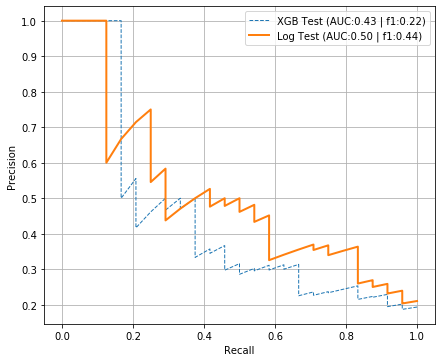

Stayers Detected (True Negatives):  98
Stayers Missed (False Positives):  25
Leavers Missed (False Negatives):  10
Leavers Detected (True Positives):  14


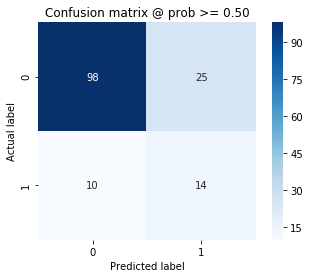

In [29]:
plt.figure(figsize=(7, 7))
plot_pr_curve("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], model_XGB.predict(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_pr_curve("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], model_logistic.predict(test_features), lcolor=colors[1], lstyle='-')
plt.legend(loc='upper right')
plt.show()
plot_cm(test_labels, model_logistic.predict_proba(test_features)[:, 1])

## 3. LinearSVC

In [30]:
from sklearn.svm import LinearSVC as LSVC

### GridSearch with Stratified K-Fold CV

In [31]:
parameters_lsvc = [{
    'C' : [i for i in range(1,10,2)],
    'penalty' : ['l1', 'l2'],
    'max_iter': [10000, 100000, 1000000]
}]

model_LinearSVC = grids_skf_lsvc(
    train_features, 
    train_labels, 
    parameters_lsvc, 
    class_weights, 
    n_folds
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s


LinearSVC(C=1, class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
          dual=False, fit_intercept=True, intercept_scaling=1,
          loss='squared_hinge', max_iter=10000, multi_class='ovr', penalty='l2',
          random_state=0, tol=0.0001, verbose=0)


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.5s finished


In [32]:
#m_summary = save_metrics(m_summary, 'model_LinearSVC', test_labels, model_LinearSVC.decision_function(test_features), split_data='test')

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_LinearSVC.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_LinearSVC', ytrain, model_LinearSVC.decision_function(xtrain), split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_LinearSVC', yval, model_LinearSVC.decision_function(xval), split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_LinearSVC', test_labels, model_LinearSVC.decision_function(test_features), split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


In [33]:
m_summary.groupby(['model', 'data']).mean().sort_values(by=['f1', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  mc_coef  batch_s
model           data                                                     
model_XGB       train  1.00  1.00    1.00    1.00  1.00     1.00      NaN
model_LinearSVC train  0.88  0.68    0.46    0.65  0.55     0.49      NaN
model_logistic  train  0.78  0.40    0.79    0.64  0.54     0.45      NaN
                val    0.76  0.38    0.74    0.58  0.50     0.40      NaN
model_LinearSVC val    0.86  0.61    0.42    0.58  0.49     0.43      NaN
model_logistic  test   0.77  0.38    0.62    0.47  0.47     0.35      NaN
model_XGB       val    0.87  0.81    0.28    0.56  0.42     0.43      NaN
model_LinearSVC test   0.84  0.52    0.20    0.46  0.29     0.25      NaN
model_XGB       test   0.85  0.73    0.13    0.43  0.22     0.27      NaN

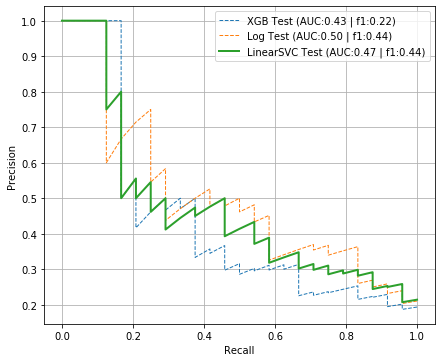

Stayers Detected (True Negatives):  118
Stayers Missed (False Positives):  5
Leavers Missed (False Negatives):  18
Leavers Detected (True Positives):  6


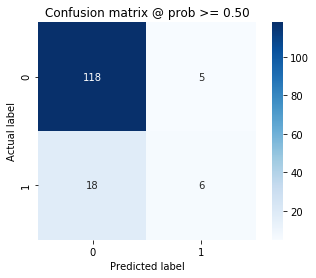

In [34]:
plt.figure(figsize=(7, 7))
plot_pr_curve("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], model_XGB.predict(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_pr_curve("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], model_logistic.predict(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_pr_curve("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), model_logistic.predict(test_features), lcolor=colors[2], lstyle='-')
plt.legend(loc='upper right')
plt.show()

plot_cm(test_labels, model_LinearSVC.decision_function(test_features))

## 4. SVC

In [35]:
from sklearn.svm import SVC

### GridSearch with Stratified K-Fold CV

In [36]:
parameters_svc = [{
    'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'],
    'C' : [i for i in range(1,10,2)],
    'gamma' : [1, 0.1],
    'coef0' : [1, 0.1],
    'shrinking' : [True, False]
}]

model_SVC = grids_skf_svc(
    train_features,
    train_labels,
    parameters_svc,
    class_weights,
    n_folds
)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   37.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=1, cache_size=200,
    class_weight={0: 0.595945945945946, 1: 3.1056338028169015}, coef0=0.1,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


In [37]:
#m_summary = save_metrics(m_summary, 'model_SVC', test_labels, model_SVC.predict_proba(test_features)[:, 1], split_data='test')

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_SVC.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_SVC', ytrain, model_SVC.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_SVC', yval, model_SVC.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_SVC', test_labels, model_SVC.predict_proba(test_features)[:, 1], split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


In [38]:
m_summary.groupby(['model', 'data']).mean().sort_values(by=['f1', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  mc_coef  batch_s
model           data                                                     
model_XGB       train  1.00  1.00    1.00    1.00  1.00     1.00      NaN
model_LinearSVC train  0.88  0.68    0.46    0.65  0.55     0.49      NaN
model_logistic  train  0.78  0.40    0.79    0.64  0.54     0.45      NaN
                val    0.76  0.38    0.74    0.58  0.50     0.40      NaN
model_LinearSVC val    0.86  0.61    0.42    0.58  0.49     0.43      NaN
model_logistic  test   0.77  0.38    0.62    0.47  0.47     0.35      NaN
model_XGB       val    0.87  0.81    0.28    0.56  0.42     0.43      NaN
model_SVC       train  0.86  0.69    0.28    0.54  0.40     0.38      NaN
                val    0.87  0.74    0.26    0.59  0.38     0.38      NaN
model_LinearSVC test   0.84  0.52    0.20    0.46  0.29     0.25      NaN
model_XGB       test   0.85  0.73    0.13    0.43  0.22     0.27      NaN
model_SVC       test   0.85  0.71    0.12    0.46  0.21     0.24      NaN

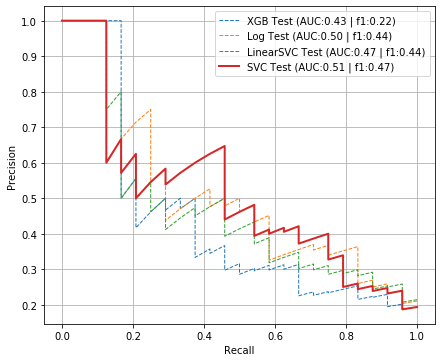

Stayers Detected (True Negatives):  119
Stayers Missed (False Positives):  4
Leavers Missed (False Negatives):  19
Leavers Detected (True Positives):  5


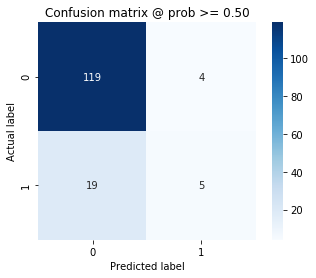

In [39]:
plt.figure(figsize=(7, 7))
plot_pr_curve("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], model_XGB.predict(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_pr_curve("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], model_logistic.predict(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_pr_curve("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), model_logistic.predict(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_pr_curve("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], model_SVC.predict(test_features), lcolor=colors[3], lstyle='-')
plt.legend(loc='upper right')
plt.show()

plot_cm(test_labels, model_SVC.predict_proba(test_features)[:, 1])

## 5. Random Forest Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier as RForest

### GridSearch with Stratified K-Fold CV

In [41]:
m_RF = RForest(criterion='gini',
               max_features='auto',
               class_weight=class_weights,
               n_jobs=-1,
               random_state=0)

parameters_rf = [{
    'n_estimators' : [100, 500, 1000],
    'max_depth' : [i for i in range(3,15,3)],
    'min_samples_split' : [i for i in range (2,4)],
    'min_samples_leaf' : [i for i in range (2,4)]
}]

model_RandomForest = grids_skf_rf(
    train_features, 
    train_labels, 
    parameters_rf, 
    class_weights, 
    n_folds
)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   36.0s


RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.595945945945946,
                                     1: 3.1056338028169015},
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   49.9s finished


In [42]:
#m_summary = save_metrics(m_summary, 'model_RandomForest', test_labels, model_RandomForest.predict_proba(test_features)[:, 1], split_data='test')

# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_feat_norm[train_indices], train_feat_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_RandomForest.fit(xtrain, ytrain)
    
    m_summary = save_metrics(m_summary, 'model_RandomForest', ytrain, model_RandomForest.predict_proba(xtrain)[:, 1], split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_RandomForest', yval, model_RandomForest.predict_proba(xval)[:, 1], split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'model_RandomForest', test_labels, model_RandomForest.predict_proba(test_features)[:, 1], split_data='test', series='imbalanced')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


In [43]:
m_summary.groupby(['model', 'data']).mean().sort_values(by=['f1', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  mc_coef  batch_s
model              data                                                     
model_XGB          train  1.00  1.00    1.00    1.00  1.00     1.00      NaN
model_RandomForest train  0.95  0.86    0.83    0.92  0.84     0.81      NaN
model_LinearSVC    train  0.88  0.68    0.46    0.65  0.55     0.49      NaN
model_logistic     train  0.78  0.40    0.79    0.64  0.54     0.45      NaN
                   val    0.76  0.38    0.74    0.58  0.50     0.40      NaN
model_LinearSVC    val    0.86  0.61    0.42    0.58  0.49     0.43      NaN
model_RandomForest val    0.86  0.58    0.42    0.54  0.49     0.41      NaN
model_logistic     test   0.77  0.38    0.62    0.47  0.47     0.35      NaN
model_XGB          val    0.87  0.81    0.28    0.56  0.42     0.43      NaN
model_SVC          train  0.86  0.69    0.28    0.54  0.40     0.38      NaN
                   val    0.87  0.74    0.26    0.59  0.38     0.38      NaN
model_LinearSVC    test   0.84  0.52    0.20    0.46  0.29     0.25      NaN
model_RandomForest test   0.81  0.37    0.20    0.38  0.26     0.18      NaN
model_XGB          test   0.85  0.73    0.13    0.43  0.22     0.27      NaN
model_SVC          test   0.85  0.71    0.12    0.46  0.21     0.24      NaN

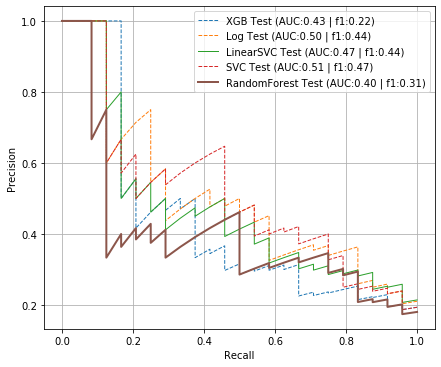

Stayers Detected (True Negatives):  114
Stayers Missed (False Positives):  9
Leavers Missed (False Negatives):  18
Leavers Detected (True Positives):  6


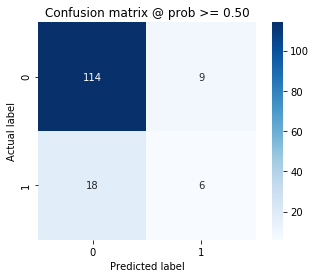

In [44]:
plt.figure(figsize=(7, 7))
plot_pr_curve("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], model_XGB.predict(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_pr_curve("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], model_logistic.predict(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_pr_curve("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), model_logistic.predict(test_features), lcolor=colors[2], lstyle='-', lwidth=1)

plot_pr_curve("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], model_SVC.predict(test_features), lcolor=colors[3], lstyle='--', lwidth=1)

plot_pr_curve("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], model_RandomForest.predict(test_features), lcolor=colors[5], lstyle='-')
plt.legend(loc='upper right')
plt.show()

plot_cm(test_labels, model_RandomForest.predict_proba(test_features)[:, 1])

## 6. Keras Tensorflow Classification NN
Designing NN:

https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

https://nanonets.com/blog/hyperparameter-optimization/

In [108]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [143]:
#metrics to obtain in history
METRICS = [
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.Accuracy(name='acc'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
]

# max number of epochs (the early stopping callback will cutoff before)
EPOCHS = 100 
#best batch size = 64, 70, 32, 128, 256
BATCH_SIZE = 32

# Defining specific callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=0,
    patience=20, #best 20
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=5,
    cooldown=6,
    min_lr=0.00001
)

callback = [
    early_stopping,
    reduce_lr
]

if n_features%2 == 0:
    n_init_neurons = n_features
else:
    n_init_neurons = n_features+1
    
print('The advisable number of neurons in the first layer should be: ', n_init_neurons)

The advisable number of neurons in the first layer should be:  42


Constructor of Keras model definition

In [144]:
def make_model(
    metrics = METRICS,
    output_bias = None, 
    learn_rate = 0.001, 
    l1_neurons = n_init_neurons, 
    l2_neurons = 24, 
    input_shape = train_features.shape[-1:], 
    l2_dropout = 0.25
):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = Sequential(
        [
            #First hidden layer
        Dense(
            l1_neurons, 
            activation=keras.layers.ELU(), 
            input_shape=input_shape,
            name='first_hidden_layer'
        ),
            #Normalization layer
        BatchNormalization(name='first_Batch_norm'),
            #Second hidden layer
        Dense(
            l2_neurons,
            activation=keras.layers.LeakyReLU(),
            name='second_hidden_layer'
        ),
            #Normalization layer
        BatchNormalization(name='second_Batch_norm'),
            #Dropout layer
        Dropout(
            l2_dropout,
            name='l2_dropout_layer'
        ),
            #Output layer
        Dense(
            1, 
            activation='sigmoid',                   # sigmoid for regressor with probability output
            bias_initializer=output_bias,
            name='output_layer'
        )
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(lr=learn_rate),
            #Optimizer to use
            #optimizer_ = keras.optimizers.RMSprop(lr=learn_rate)
            #optimizer=keras.optimizers.Nadam(lr=learn_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

In [145]:
make_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_hidden_layer (Dense)   (None, 42)                1764      
_________________________________________________________________
first_Batch_norm (BatchNorma (None, 42)                168       
_________________________________________________________________
second_hidden_layer (Dense)  (None, 24)                1032      
_________________________________________________________________
second_Batch_norm (BatchNorm (None, 24)                96        
_________________________________________________________________
l2_dropout_layer (Dropout)   (None, 24)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 25        
Total params: 3,085
Trainable params: 2,953
Non-trainable params: 132
____________________________________________________

### Bayesian Optimization on weighted model
Bayesian Optimization on the train dataset to better tune hyperparameters on the model.

In [146]:
from sklearn.model_selection import train_test_split

Defining black box function

In [150]:
def fit_with(
    learn_rate, 
    l1_neurons, 
    l2_neurons, 
    l2_dropout,
    BATCH_SIZE,
    X = train_features,
    y = train_labels
):
    X = np.array(train_features)
    y = train_labels
    # Split of data for evaluation (random state defined)
    X, X_val, y, y_val = train_test_split(X, y, stratify=y, random_state=0, test_size=0.1)
    # Instatiate model
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(y)
    initial_bias = np.log([pos_nn/neg_nn])
    
    # Discretize parameters
    l1_neurons = max(int(l1_neurons)*2, 32)
    l2_neurons = max(int(l2_neurons)*2, 2)
    BATCH_SIZE = max(int(BATCH_SIZE)*64, 32)
    
    model_keras_opt = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = 0.001,
        l1_neurons = n_init_neurons,
        l2_neurons = 24,
        input_shape = X.shape[-1:],
        l2_dropout = 0.25
    )
    
    results = model_keras_opt.evaluate(minmax.fit_transform(X_val), y_val, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_opt.save_weights(initial_weights)
    
    # Trainning of the model on the training features
    model_keras_opt.fit(
        minmax.fit_transform(X),
        y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks = callback,
        validation_data=(minmax.fit_transform(X_val), y_val),
        class_weight=class_weights,
        verbose=0
    )
    
    # Evaluation of model with validation data
    scores = model_keras_opt.evaluate(
        x=X_val, 
        y=y_val,
        verbose=0
    )
        
    tn = scores[5]
    tp = scores[6]
    fn = scores[7]
    fp = scores[8]
    mc_coef = (tp * tn + fp * fn) / (np.sqrt((tp + fp)(tp + fn)(tn + fp)(tn + fn))+1e-7)
    # The target score to maximize, in this case we think the best is recall
    return mc_coef

In [136]:
from functools import partial
fit_with_partial = partial(fit_with)

In [137]:
from bayes_opt import BayesianOptimization

In [138]:
p_bounds = {
    'learn_rate':(1e-4, 1e-1), 
    'l1_neurons':(16, 42), # max(int(i)*2, 32)
    'l2_neurons':(1, 14), # max(int(i)*2, 2)
    'l2_dropout':(0, 0.8),
    'BATCH_SIZE':(0.5, 4.6), # max(int(i)*64, 32)
}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=p_bounds,
    verbose=1,
    random_state=0
)

optimizer.maximize(
    init_points=10,
    n_iter=20
)

#for i, res in enumerate(optimizer.res):
#    print('Iteration {}: \n\t{}'.format(i, res))

print('learn_rate:', optimizer.max['params']['learn_rate'])
print('l1_neurons:', max(int(optimizer_smote.max['params']['l1_neurons'])*2, 32))
print('l2_neurons:', max(int(optimizer_smote.max['params']['l2_neurons'])*2, 2))
print('l2_dropout:', optimizer.max['params']['l2_dropout'])
print('BATCH_SIZE:', max(int(optimizer_smote.max['params']['BATCH_SIZE'])*64, 32)

|   iter    |  target   | BATCH_... | l1_neu... | l2_dro... | l2_neu... | learn_... |
-------------------------------------------------------------------------------------
|  8        |  0.3175   |  3.032    |  31.91    |  0.4935   |  13.27    |  0.06821  |
|  14       |  0.3306   |  4.6      |  16.0     |  0.0      |  14.0     |  0.0001   |
learn_rate: 0.0001
l1_neurons: 32
l2_neurons: 28
l2_dropout: 0.0
BATCH_SIZE: 256


In [54]:
import time
timestamp = time.gmtime()

with open('../logs/nn_opt_log.txt', 'a') as file:
    file.write(str(timestamp) + '\n')
    file.write('imbalanced: ' + str(optimizer.max) + '\n')
    file.write('---------------------------------------------------------------- \n')
file.close()

In [139]:
learn_rate = optimizer_smote.max['params']['learn_rate']
l1_neurons = max(int(optimizer_smote.max['params']['l1_neurons'])*2, 32)
l2_neurons = max(int(optimizer_smote.max['params']['l2_neurons'])*2, 2)
l2_dropout = optimizer_smote.max['params']['l2_dropout']
BATCH_SIZE = max(int(optimizer_smote.max['params']['BATCH_SIZE'])*64, 32)

tf.keras.backend.clear_session()

### Cross Validation with Stratified K-Fold

In [140]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

train_feat_norm = minmax.fit_transform(train_features)

model_keras_w_history = []
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_feat_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    
    # Generate batches from indices
    X, X_val = train_feat_norm[train_indices], train_feat_norm[val_indices]
    y, y_val = train_labels[train_indices], train_labels[val_indices]
    
    # Clear model
    model_keras_w = None
    
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(ytrain)
    initial_bias = np.log([pos_nn/neg_nn])
    
    model_keras_w = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = learn_rate,
        l1_neurons = l1_neurons,
        l2_neurons = l2_neurons,
        input_shape = X.shape[-1:],
        l2_dropout = l2_dropout
    )
    
    results = model_keras_w.evaluate(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_w.save_weights(initial_weights)

    baseline_history = model_keras_w.fit(
        X,
        y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = callback,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        verbose=0)
    
    model_keras_w_history.append(baseline_history)
    m_summary = save_metrics(m_summary, 'NN_weighted', ytrain, model_keras_w.predict_proba(xtrain), batch_size=BATCH_SIZE, split_data='train', series='imbalanced')
    m_summary = save_metrics(m_summary, 'NN_weighted', yval, model_keras_w.predict_proba(xval), batch_size=BATCH_SIZE, split_data='val', series='imbalanced')
    m_summary = save_metrics(m_summary, 'NN_weighted', test_labels, model_keras_w.predict_proba(test_features), batch_size=BATCH_SIZE, split_data='test', series='imbalanced')
print('...Done')

tf.keras.backend.clear_session()

Training on fold 1/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training on fold 2/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 3/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 4/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 5/5...
...Done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [57]:
m_summary.groupby(['model', 'data']).mean().sort_values(by=['f1', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

,,acc,prec,recall,pr_auc,f1,mc_coef,batch_s
model,data,,,,,,,
model_XGB,train,1.00,1.00,1.00,1.00,1.00,1.00,NaN
model_RandomForest,train,0.95,0.86,0.83,0.92,0.84,0.81,NaN
model_LinearSVC,train,0.88,0.68,0.46,0.65,0.55,0.49,NaN
model_logistic,train,0.78,0.40,0.79,0.64,0.54,0.45,NaN
NN_weighted,val,0.88,0.83,0.45,0.69,0.52,0.53,128.0
model_logistic,val,0.76,0.38,0.74,0.58,0.50,0.40,NaN
model_LinearSVC,val,0.86,0.61,0.42,0.58,0.49,0.43,NaN
model_RandomForest,val,0.86,0.58,0.42,0.54,0.49,0.41,NaN
NN_weighted,train,0.88,0.82,0.41,0.67,0.48,0.49,128.0


Metrics for fold nr: 1
Metrics for fold nr: 2
Metrics for fold nr: 3
Metrics for fold nr: 4
Metrics for fold nr: 5


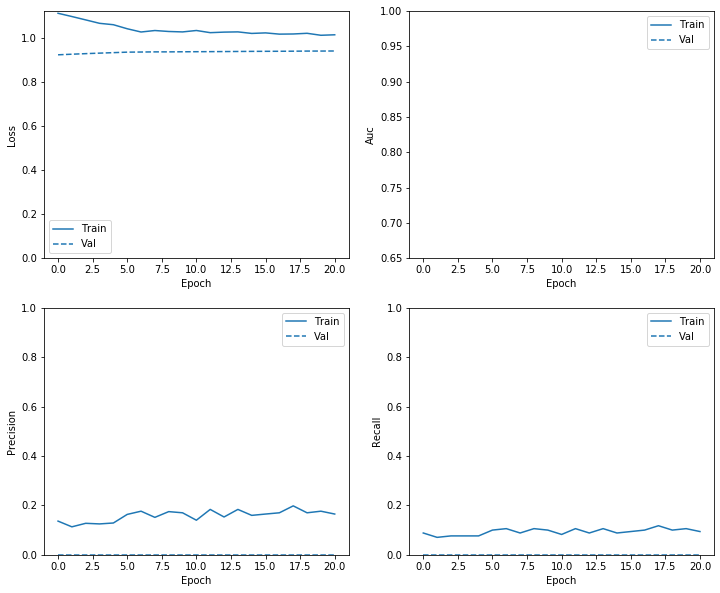

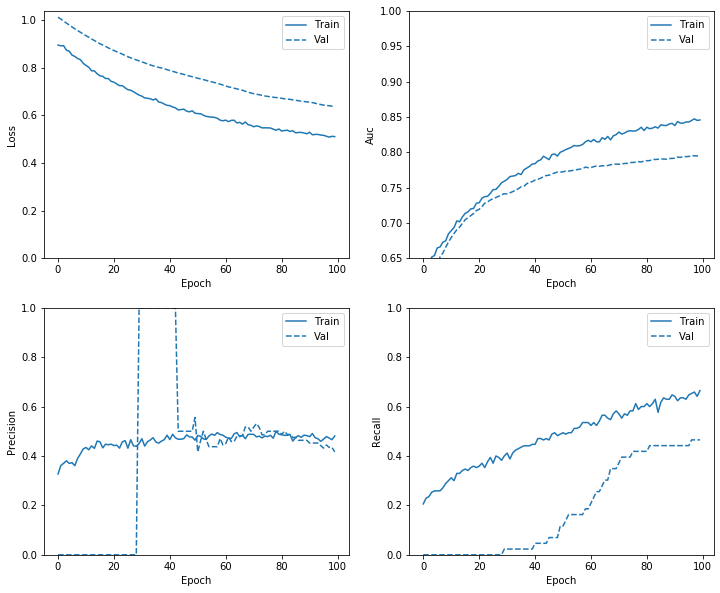

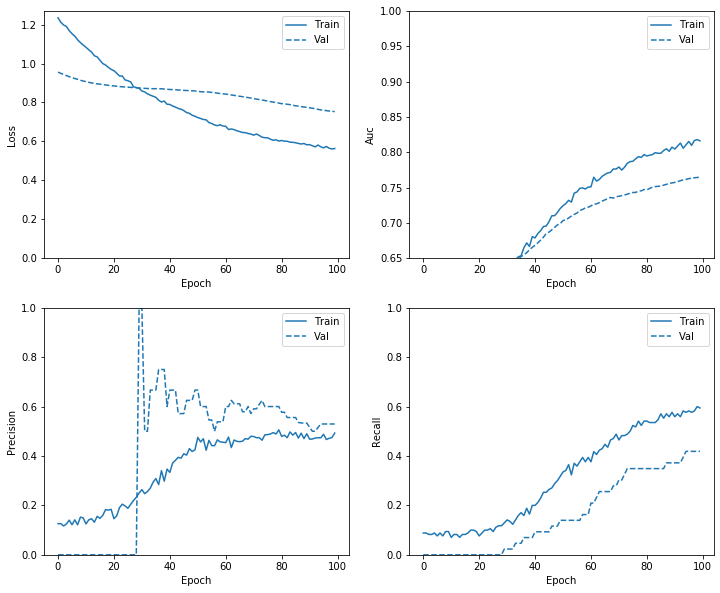

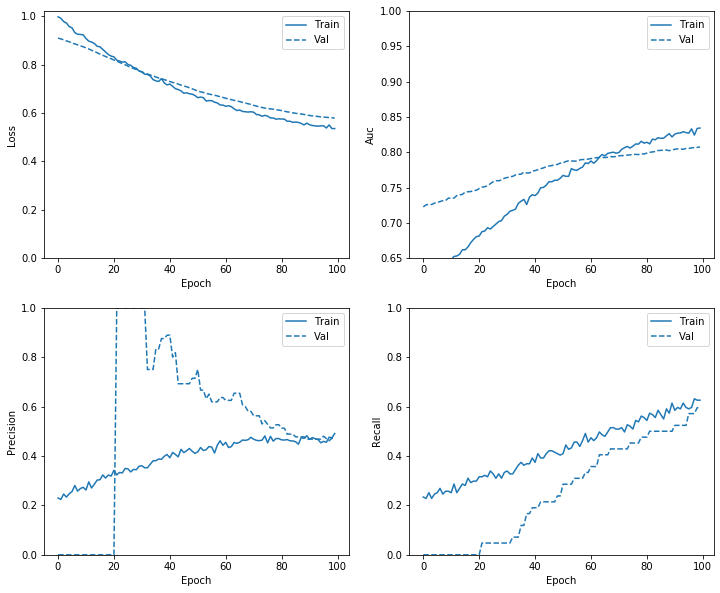

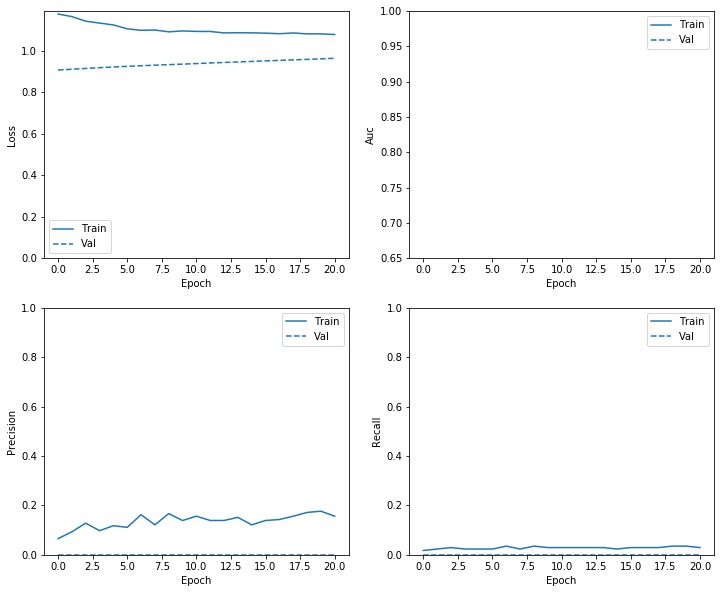

In [141]:
for i, h in enumerate(model_keras_w_history):
    print('Metrics for fold nr:', i+1)
    plot_nn_metrics(h)

In [59]:
#train_predictions_weighted = model_keras_w.predict_proba(train_feat_norm, batch_size=BATCH_SIZE)
test_predictions_weighted = model_keras_w.predict_proba(test_features, batch_size=BATCH_SIZE)

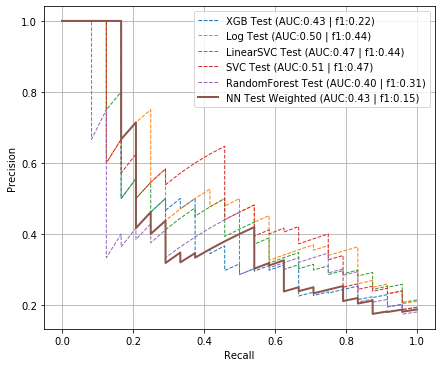

In [60]:
plt.figure(figsize=(7, 7))
plot_pr_curve("XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], model_XGB.predict(test_features), lcolor=colors[0], lstyle='--', lwidth=1)

plot_pr_curve("Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], model_logistic.predict(test_features), lcolor=colors[1], lstyle='--', lwidth=1)

plot_pr_curve("LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), model_LinearSVC.predict(test_features), lcolor=colors[2], lstyle='--', lwidth=1)

plot_pr_curve("SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], model_SVC.predict(test_features), lcolor=colors[3], lstyle='--', lwidth=1)

plot_pr_curve("RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], model_RandomForest.predict(test_features), lcolor=colors[4], lstyle='--', lwidth=1)

plot_pr_curve("NN Test Weighted", test_labels, test_predictions_weighted, model_keras_w.predict_classes(test_features, batch_size=BATCH_SIZE), lcolor=colors[5], lstyle='-')

plt.legend(loc='upper right')
plt.show()

# Further model exploration

In [61]:
m_summary.groupby(['model', 'data', 'series']).mean().sort_values(by=['mc_coef', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

,,,acc,prec,recall,pr_auc,f1,mc_coef,batch_s
model,data,series,,,,,,,
model_XGB,train,imbalanced,1.00,1.00,1.00,1.00,1.00,1.00,NaN
model_RandomForest,train,imbalanced,0.95,0.86,0.83,0.92,0.84,0.81,NaN
NN_weighted,val,imbalanced,0.88,0.83,0.45,0.69,0.52,0.53,128.0
model_LinearSVC,train,imbalanced,0.88,0.68,0.46,0.65,0.55,0.49,NaN
NN_weighted,train,imbalanced,0.88,0.82,0.41,0.67,0.48,0.49,128.0
model_logistic,train,imbalanced,0.78,0.40,0.79,0.64,0.54,0.45,NaN
model_LinearSVC,val,imbalanced,0.86,0.61,0.42,0.58,0.49,0.43,NaN
model_XGB,val,imbalanced,0.87,0.81,0.28,0.56,0.42,0.43,NaN
model_RandomForest,val,imbalanced,0.86,0.58,0.42,0.54,0.49,0.41,NaN


## A. UpSampling with SMOTE

reformulate

https://stats.stackexchange.com/questions/269821/should-smote-oversampling-be-done-before-or-after-holdout-validations-training?noredirect=1

https://stackoverflow.com/questions/55591063/how-to-perform-smote-with-cross-validation-in-sklearn-in-python

In [62]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

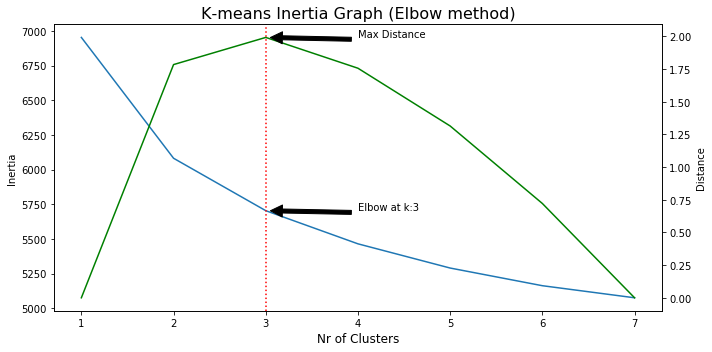

The best number of clusters is 3


3

In [63]:
plot_elbow_kmeans(minmax.fit_transform(finaldf))

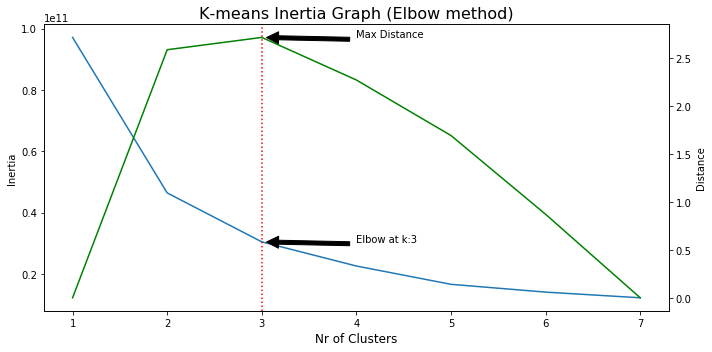

The best number of clusters is 3


In [64]:
n_kn = plot_elbow_kmeans(train_features)

In [65]:
smote = SMOTE(k_neighbors=n_kn)

In [66]:
X_SMOTE, y_SMOTE = smote.fit_sample(train_features, train_labels)

X_SMOTE_mm = minmax.fit_transform(X_SMOTE)

In [67]:
# fit model on training data
model_XGB_smote = grids_skf_xgb(
    X_SMOTE_mm,
    y_SMOTE, 
    parameters_XGB, 
    n_folds
)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  3.1min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, seed=123,
              silent=None, subsample=0.5, verbosity=0)


In [68]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)

# vectorize
train_features_v = np.array(train_features)

In [69]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    
    # train model
    model_XGB_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(m_summary, 'model_XGB', ytrain_SMOTE, model_XGB_smote.predict_proba(xtrain_SMOTE)[:, 1], split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_XGB', yval, model_XGB_smote.predict_proba(xval)[:, 1], split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_XGB', test_labels, model_XGB_smote.predict_proba(test_features)[:, 1], split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 2/5...
Training on fold 3/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 4/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 5/5...
...Done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [70]:
model_logistic_smote = grids_skf_lr(
    X_SMOTE_mm,
    y_SMOTE, 
    parameters_log,
    {0: 1, 1: 1},
    n_folds
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.4s


LogisticRegression(C=10, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=-1, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=0,
                   warm_start=True)


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   19.5s finished


In [71]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    
    # train model
    model_logistic_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(m_summary, 'model_logistic', ytrain_SMOTE, model_logistic.predict_proba(xtrain_SMOTE)[:, 1], split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_logistic', yval, model_logistic.predict_proba(xval)[:, 1], split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_logistic', test_labels, model_logistic.predict_proba(test_features)[:, 1], split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 2/5...
Training on fold 3/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 4/5...
Training on fold 5/5...
...Done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [72]:
model_LinearSVC_smote = grids_skf_lsvc(
    X_SMOTE_mm, 
    y_SMOTE, 
    parameters_lsvc,
    {0: 1, 1: 1},
    n_folds
)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.8s finished


LinearSVC(C=7, class_weight={0: 1, 1: 1}, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l1', random_state=0, tol=0.0001,
          verbose=0)


In [73]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    
    # train model
    model_LinearSVC_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(m_summary, 'model_LinearSVC', ytrain_SMOTE, model_LinearSVC_smote.decision_function(xtrain_SMOTE), split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_LinearSVC', yval, model_LinearSVC_smote.decision_function(xval), split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_LinearSVC', test_labels, model_LinearSVC_smote.decision_function(test_features), split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


In [74]:
model_SVC_smote = grids_skf_svc(
    X_SMOTE_mm,
    y_SMOTE,
    parameters_svc,
    {0: 1, 1: 1},
    n_folds
)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.6min finished


SVC(C=3, cache_size=200, class_weight={0: 1, 1: 1}, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


In [75]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    
    # train model
    model_SVC_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(m_summary, 'model_SVC', ytrain_SMOTE, model_SVC_smote.predict_proba(xtrain_SMOTE)[:, 1], split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_SVC', yval, model_SVC_smote.predict_proba(xval)[:, 1], split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_SVC', test_labels, model_SVC_smote.predict_proba(test_features)[:, 1], split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-def

Training on fold 2/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-def

Training on fold 3/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-def

Training on fold 4/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-def

Training on fold 5/5...
...Done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-def

In [76]:
model_RandomForest_smote = grids_skf_rf(
    X_SMOTE_mm, 
    y_SMOTE, 
    parameters_rf, 
    {0: 1, 1: 1}, 
    n_folds
)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.2min finished


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)


In [77]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    
    # train model
    model_RandomForest_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(m_summary, 'model_RandomForest', ytrain_SMOTE, model_RandomForest_smote.predict_proba(xtrain_SMOTE)[:, 1], split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_RandomForest', yval, model_RandomForest_smote.predict_proba(xval)[:, 1], split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'model_RandomForest', test_labels, model_RandomForest_smote.predict_proba(test_features)[:, 1], split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...
Training on fold 4/5...
Training on fold 5/5...
...Done


In [78]:
def fit_with_smote(
    learn_rate, 
    l1_neurons, 
    l2_neurons, 
    l2_dropout,
    BATCH_SIZE,
    X = X_SMOTE_mm,
    y = y_SMOTE
):
    X = np.array(train_features)
    y = train_labels
    # Split of data for evaluation (random state defined)
    X, X_val, y, y_val = train_test_split(X, y, stratify=y, random_state=0, test_size=0.1)
    # Instatiate model
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(y)
    initial_bias = np.log([pos_nn/neg_nn])
    
    # Discretize parameters
    l1_neurons = max(int(l1_neurons)*2, 32)
    l2_neurons = max(int(l2_neurons)*2, 2)
    BATCH_SIZE = max(int(BATCH_SIZE)*64, 32)
    
    model_keras_opt_smote = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = 0.001,
        l1_neurons = n_init_neurons,
        l2_neurons = 24,
        input_shape = X.shape[-1:],
        l2_dropout = 0.25
    )
    
    results = model_keras_opt_smote.evaluate(minmax.fit_transform(X_val), y_val, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_opt_smote.save_weights(initial_weights)
    
    # Trainning of the model on the training features
    model_keras_opt_smote.fit(
        minmax.fit_transform(X),
        y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks = callback,
        validation_data=(minmax.fit_transform(X_val), y_val),
        verbose=0
    )
    
    # Evaluation of model with validation data
    scores = model_keras_opt_smote.evaluate(
        x=X_val, 
        y=y_val,
        verbose=0
    )
    
    tn = scores[5]
    tp = scores[6]
    fn = scores[7]
    fp = scores[8]
    mc_coef = (tp * tn + fp * fn) / (np.sqrt((tp + fp)(tp + fn)(tn + fp)(tn + fn))+1e-7)
    # The target score to maximize, in this case we think the best is recall
    return mc_coef

In [79]:
fit_with_partial_smote = partial(fit_with_smote)

optimizer_smote = BayesianOptimization(
    f=fit_with_partial_smote,
    pbounds=p_bounds,
    verbose=1,
    random_state=0
)

optimizer_smote.maximize(
    init_points=10,
    n_iter=100
)

#for i, res in enumerate(optimizer.res):
#    print('Iteration {}: \n\t{}'.format(i, res))

print('learn_rate:', optimizer_smote.max['params']['learn_rate'])
print('l1_neurons:', max(int(optimizer_smote.max['params']['l1_neurons'])*2, 32)
print('l2_neurons:', max(int(optimizer_smote.max['params']['l2_neurons'])*2, 2)
print('l2_dropout:', optimizer_smote.max['params']['l2_dropout'])
print('BATCH_SIZE:', max(int(optimizer_smote.max['params']['BATCH_SIZE'])*64, 32)

|   iter    |  target   | BATCH_... | l1_neu... | l2_dro... | l2_neu... | learn_... |
-------------------------------------------------------------------------------------
|  3        |  0.8095   |  3.746    |  29.75    |  0.4544   |  13.03    |  0.007197 |
|  4        |  1.0      |  0.8572   |  16.53    |  0.6661   |  11.12    |  0.08701  |
learn_rate: 0.08701421360985724
l1_neurons: 32
l2_neurons: 22
l2_dropout: 0.6660958764383504
BATCH_SIZE: 0


In [80]:
import time
timestamp = time.gmtime()

with open('../logs/nn_opt_log.txt', 'a') as file:
    file.write(str(timestamp) + '\n')
    file.write('smote: ' + str(optimizer_smote.max) + '\n')
    file.write('---------------------------------------------------------------- \n')
file.close()

In [81]:
learn_rate = optimizer_smote.max['params']['learn_rate']
l1_neurons = max(int(optimizer_smote.max['params']['l1_neurons'])*2, 32)
l2_neurons = max(int(optimizer_smote.max['params']['l2_neurons'])*2, 2)
l2_dropout = optimizer_smote.max['params']['l2_dropout']
BATCH_SIZE = max(int(optimizer_smote.max['params']['BATCH_SIZE'])*64, 32)

tf.keras.backend.clear_session()

In [84]:
model_keras_smote_history = []
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...")
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    
    # Clear model
    model_keras_smote = None
    
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(ytrain_SMOTE)
    initial_bias = np.log([pos_nn/neg_nn])
    model_keras_smote = make_model(output_bias = initial_bias)
    results = model_keras_smote.evaluate(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_smote.save_weights(initial_weights)

    baseline_history_smote = model_keras_smote.fit(
        xtrain_SMOTE,
        ytrain_SMOTE,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = callback,
        validation_data=(xval, yval),
        verbose=0)
    
    # Debug message
    # print "Training new iteration on " + str(xtrain.shape[0]) + " training samples, " + str(xval.shape[0]) + " validation samples, this may be a while..."
    
    model_keras_smote_history.append(baseline_history_smote)
    m_summary = save_metrics(m_summary, 'NN_weighted', ytrain_SMOTE, model_keras_smote.predict_proba(xtrain_SMOTE), batch_size=BATCH_SIZE, split_data='train', series='SMOTE')
    m_summary = save_metrics(m_summary, 'NN_weighted', yval, model_keras_smote.predict_proba(xval), batch_size=BATCH_SIZE, split_data='val', series='SMOTE')
    m_summary = save_metrics(m_summary, 'NN_weighted', test_labels, model_keras_smote.predict_proba(test_features), batch_size=BATCH_SIZE, split_data='test', series='SMOTE')
print('...Done')

Training on fold 1/5...
Training on fold 2/5...
Training on fold 3/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 4/5...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Training on fold 5/5...
...Done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Metrics for fold nr: 1
Metrics for fold nr: 2
Metrics for fold nr: 3
Metrics for fold nr: 4
Metrics for fold nr: 5


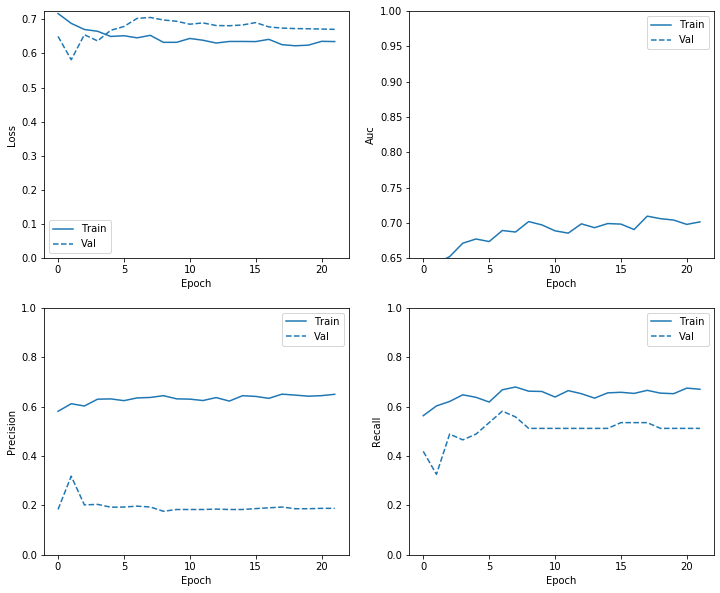

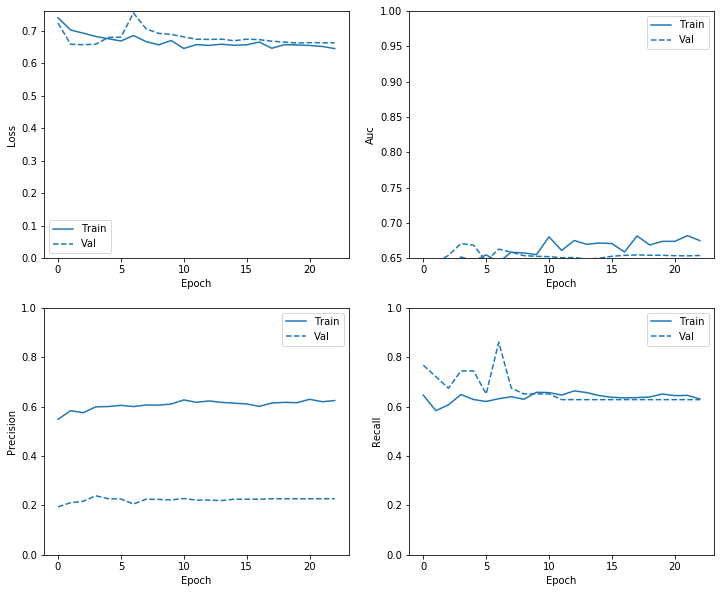

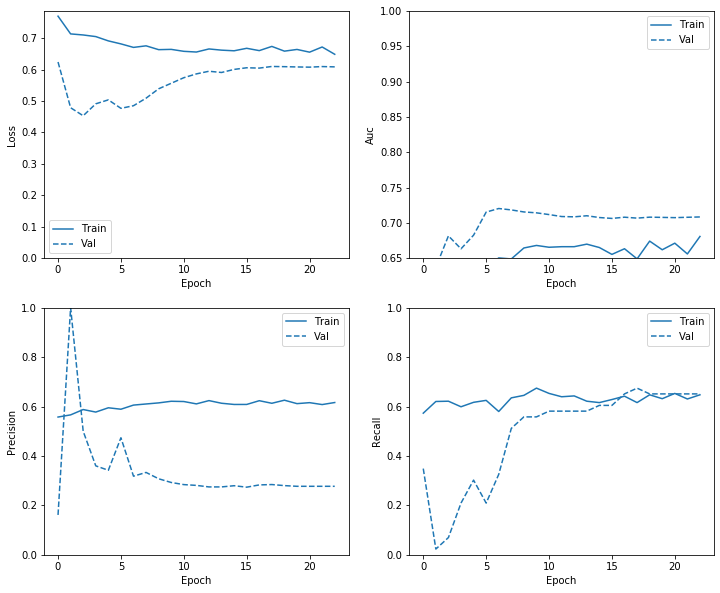

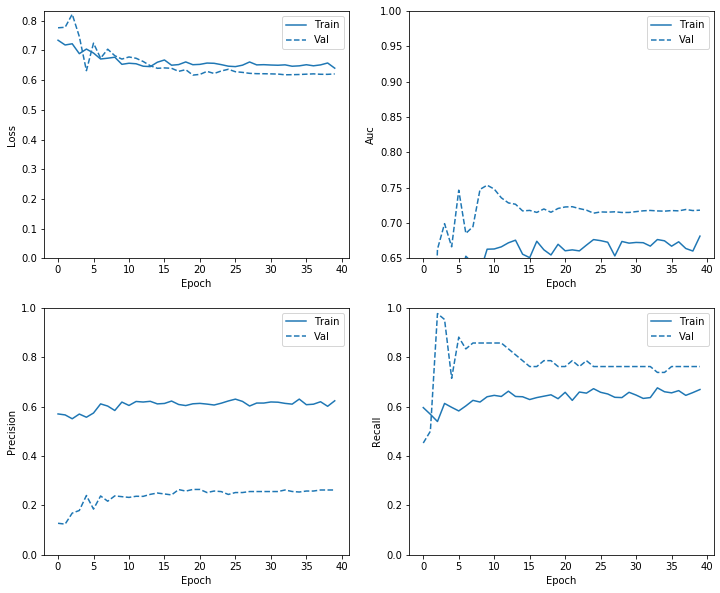

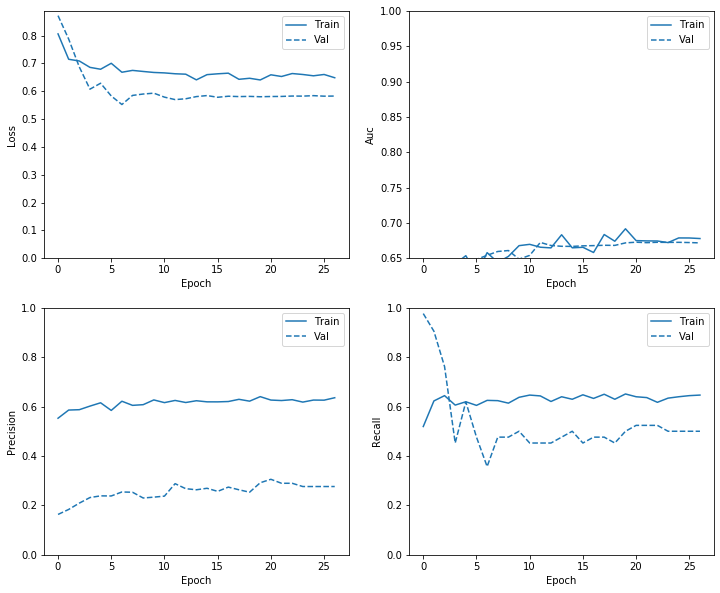

In [85]:
for i, h in enumerate(model_keras_smote_history):
    print('Metrics for fold nr:', i+1)
    plot_nn_metrics(h)

In [86]:
m_summary.to_csv('../logs/metrics_summary.csv')

In [87]:
m_summary.groupby(['model', 'data', 'series']).mean().sort_values(by=['mc_coef', 'recall'], ascending=False).applymap(lambda x: np.round(x,2))

acc  prec  recall  pr_auc    f1  \
model              data  series                                         
model_SVC          train SMOTE       1.00  1.00    1.00    1.00  1.00   
model_XGB          train imbalanced  1.00  1.00    1.00    1.00  1.00   
                         SMOTE       1.00  1.00    1.00    1.00  1.00   
model_RandomForest train SMOTE       0.99  1.00    0.99    1.00  0.99   
                         imbalanced  0.95  0.86    0.83    0.92  0.84   
NN_weighted        val   imbalanced  0.88  0.83    0.45    0.69  0.52   
model_LinearSVC    train SMOTE       0.73  0.91    0.52    0.89  0.66   
                         imbalanced  0.88  0.68    0.46    0.65  0.55   
NN_weighted        train imbalanced  0.88  0.82    0.41    0.67  0.48   
model_XGB          val   SMOTE       0.87  0.63    0.44    0.58  0.52   
model_LinearSVC    val   SMOTE       0.86  0.59    0.48    0.57  0.53   
model_logistic     train imbalanced  0.78  0.40    0.79    0.64  0.54   
model_LinearSVC    val   imbalanced  0.86  0.61    0.42    0.58  0.49   
model_XGB          val   imbalanced  0.87  0.81    0.28    0.56  0.42   
model_RandomForest val   imbalanced  0.86  0.58    0.42    0.54  0.49   
model_logistic     val   imbalanced  0.76  0.38    0.74    0.58  0.50   
model_SVC          val   imbalanced  0.87  0.74    0.26    0.59  0.38   
                   train imbalanced  0.86  0.69    0.28    0.54  0.40   
model_logistic     test  imbalanced  0.77  0.38    0.62    0.47  0.47   
model_RandomForest val   SMOTE       0.86  0.71    0.22    0.56  0.34   
model_logistic     test  SMOTE       0.76  0.36    0.58    0.50  0.44   
NN_weighted        test  imbalanced  0.84  0.74    0.19    0.42  0.26   
model_XGB          test  imbalanced  0.85  0.73    0.13    0.43  0.22   
NN_weighted        train SMOTE       0.61  0.70    0.47    0.69  0.51   
model_LinearSVC    test  imbalanced  0.84  0.52    0.20    0.46  0.29   
model_SVC          test  imbalanced  0.85  0.71    0.12    0.46  0.21   
NN_weighted        val   SMOTE       0.70  0.31    0.44    0.31  0.29   
model_RandomForest test  imbalanced  0.81  0.37    0.20    0.38  0.26   
                         SMOTE       0.23  0.17    0.98    0.28  0.29   
model_LinearSVC    test  SMOTE       0.20  0.17    1.00    0.38  0.29   
model_XGB          test  SMOTE       0.17  0.16    1.00    0.29  0.28   
NN_weighted        test  SMOTE       0.44  0.11    0.59    0.24  0.18   
model_logistic     train SMOTE       0.50  0.50    1.00    0.75  0.67   
                   val   SMOTE       0.16  0.16    1.00    0.58  0.28   
model_SVC          test  SMOTE       0.84  0.00    0.00    0.58  0.00   
                   val   SMOTE       0.84  0.00    0.00    0.58  0.00   

                                     mc_coef  batch_s  
model              data  series                        
model_SVC          train SMOTE          1.00      NaN  
model_XGB          train imbalanced     1.00      NaN  
                         SMOTE          1.00      NaN  
model_RandomForest train SMOTE          0.99      NaN  
                         imbalanced     0.81      NaN  
NN_weighted        val   imbalanced     0.53    128.0  
model_LinearSVC    train SMOTE          0.51      NaN  
                         imbalanced     0.49      NaN  
NN_weighted        train imbalanced     0.49    128.0  
model_XGB          val   SMOTE          0.46      NaN  
model_LinearSVC    val   SMOTE          0.45      NaN  
model_logistic     train imbalanced     0.45      NaN  
model_LinearSVC    val   imbalanced     0.43      NaN  
model_XGB          val   imbalanced     0.43      NaN  
model_RandomForest val   imbalanced     0.41      NaN  
model_logistic     val   imbalanced     0.40      NaN  
model_SVC          val   imbalanced     0.38      NaN  
                   train imbalanced     0.38      NaN  
model_logistic     test  imbalanced     0.35      NaN  
model_RandomForest val   SMOTE          0.34      NaN  
model_logistic     test  SMOTE 

In [88]:
m_summary_melted = pd.melt(
    m_summary, 
    id_vars=['model', 'data', 'series'], 
    value_vars=[
        'tp', 'fp', 'tn', 'fn', 
        'acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef'
    ], 
    var_name='metrics', 
    value_name='values')

m_summary_melted.to_csv('../logs/metrics_summary_melted.csv')

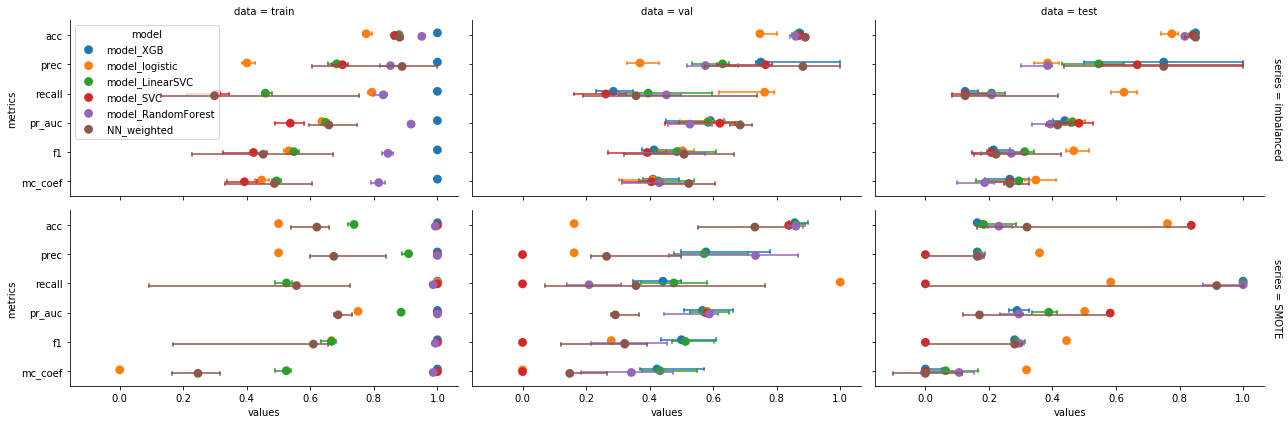

In [89]:
sb.catplot(
    x='values',
    y='metrics',
    hue='model',
    data=m_summary_melted[m_summary_melted.metrics.isin(['acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef'])], 
    row='series', 
    col='data',
    estimator= np.median,
    ci=95, 
    n_boot=1000, 
    kind='point', 
    height=3,
    aspect=2, 
    palette='tab10', 
    legend=True, 
    legend_out=False, 
    sharex=True, 
    sharey=True, 
    margin_titles=True, 
    **{
        'linestyles':'',
        'dodge':True,
        'capsize':0.1,
        'errwidth':1.5
    }
)
plt.tight_layout()
plt.show()

## C. Recursive Feature Selection with Stratified Kfold CV

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\ProgramData\Anaconda3\lib\site-packages\s

Optimal number of features : 17


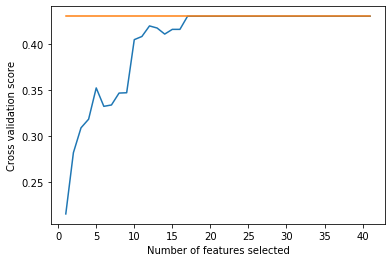

In [90]:
from sklearn.feature_selection import RFECV

# Logistic Model
rfecv = RFECV(estimator=model_logistic, step=1, cv=StratifiedKFold(5, shuffle=True, random_state=0),
              scoring='f1')
#rfecv.fit(finaldf.drop(['Attrition_Yes'], axis=1), finaldf.Attrition_Yes)
rfecv.fit(test_features, test_labels)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), [max(rfecv.grid_scores_) for i in range(1, len(rfecv.grid_scores_) + 1)])
plt.show()

In [91]:
l = []
for (i, feat), rank in zip(enumerate(test_df.columns), rfecv.ranking_):
    if rank == 1:
        l.append((feat, i))
print('Best ranking features:\n',l)

Best ranking features:
 [('EnvironmentSatisfaction', 4), ('HourlyRate', 5), ('JobInvolvement', 6), ('MonthlyRate', 9), ('RelationshipSatisfaction', 12), ('StockOptionLevel', 13), ('TrainingTimesLastYear', 14), ('YearsInCurrentRole', 16), ('Attrition_Yes', 20), ('BusinessTravel_NonTravel', 21), ('EducationField_Other', 28), ('EducationField_TechnicalDegree', 29), ('JobRole_HumanResources', 31), ('JobRole_ResearchDirector', 35), ('JobRole_ResearchScientist', 36), ('MaritalStatus_Married', 39), ('MaritalStatus_Single', 40)]


## D. Feature importance

### D.1 Logistic Model

In [92]:
from scipy import stats
params = np.append(model_logistic.intercept_,model_logistic.coef_)
predictions = model_logistic.predict(test_features)

newX = pd.DataFrame({"Constant":np.ones(len(test_features))}).join(pd.DataFrame(test_features))
MSE = (sum((test_labels-predictions)**2))/(len(newX)-len(newX.columns))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["features"],myDF3["coef"],myDF3["se"],myDF3["t_values"],myDF3["p_value"] = [test_df.columns.to_list(), params,sd_b,ts_b,p_values]
myDF3[myDF3['p_value'] < 0.05].sort_values(by=['coef'], ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


,features,coef,se,t_values,p_value
18,YearsWithCurrManager,2.0547,0.363,5.659,0.000
41,OverTime_Yes,1.7594,0.134,13.083,0.000
40,MaritalStatus_Single,1.3357,0.189,7.052,0.000
3,Education,1.1553,0.181,6.383,0.000
32,JobRole_LaboratoryTechnician,0.9382,0.269,3.492,0.001
10,PercentSalaryHike,0.6451,0.187,3.446,0.001
39,MaritalStatus_Married,0.3899,0.141,2.764,0.006
13,StockOptionLevel,-0.3225,0.147,-2.193,0.030
22,BusinessTravel_Rarely,-0.3972,0.142,-2.800,0.006
16,YearsInCurrentRole,-0.8493,0.230,-3.692,0.000


Least important features:

In [93]:
myDF3[myDF3['p_value'] > 0.05].sort_values(by=['coef'], ascending=False)

,features,coef,se,t_values,p_value
38,JobRole_SalesRepresentative,1.1705,0.617,1.896,0.060
29,EducationField_TechnicalDegree,0.8116,0.663,1.224,0.223
36,JobRole_ResearchScientist,0.2167,0.260,0.834,0.406
30,Gender_Male,0.2054,0.114,1.797,0.074
4,EnvironmentSatisfaction,0.1479,0.268,0.551,0.582
28,EducationField_Other,0.0917,0.664,0.138,0.890
34,JobRole_ManufacturingDirector,0.0486,0.241,0.202,0.840
37,JobRole_SalesExecutive,0.0000,0.573,0.000,1.000
33,JobRole_Manager,0.0000,0.532,0.000,1.000
1,DailyRate,0.0000,0.334,0.000,1.000


### D.2 XGBoost

In [94]:
import xgboost

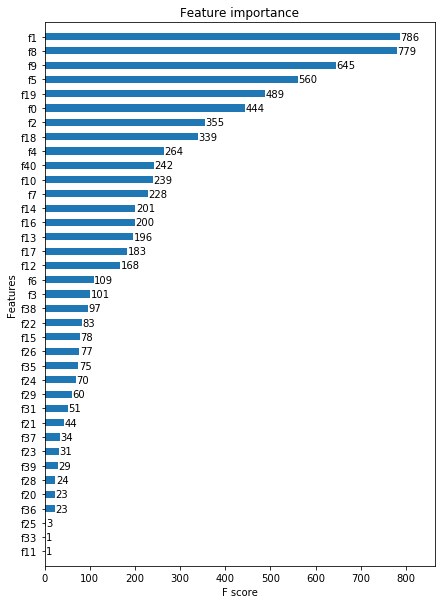

In [95]:
fig, ax = plt.subplots(1,1,figsize=(7,10))
#model_XGB.get_booster().feature_names = train_df.columns
xgboost.plot_importance(model_XGB, height=0.5, ax=ax, grid=False)
plt.show()

### D.3 LinearSVC

In [96]:
lsvc = pd.DataFrame({'features':train_features.columns, 'coefs':model_LinearSVC.coef_.ravel()}).sort_values(by='coefs')
lsvc_pos_class = lsvc[lsvc.coefs > 0].sort_values(by='coefs', ascending=False)
lsvc_neg_class = lsvc[lsvc.coefs < 0].sort_values(by='coefs', ascending=True)

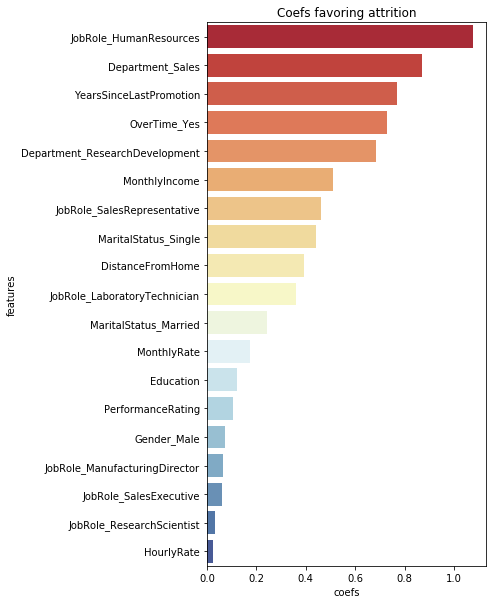

In [97]:
plt.figure(figsize=(5,10))
sb.barplot(lsvc_pos_class.coefs, lsvc_pos_class.features, palette="RdYlBu")
plt.title('Coefs favoring attrition')
plt.show()

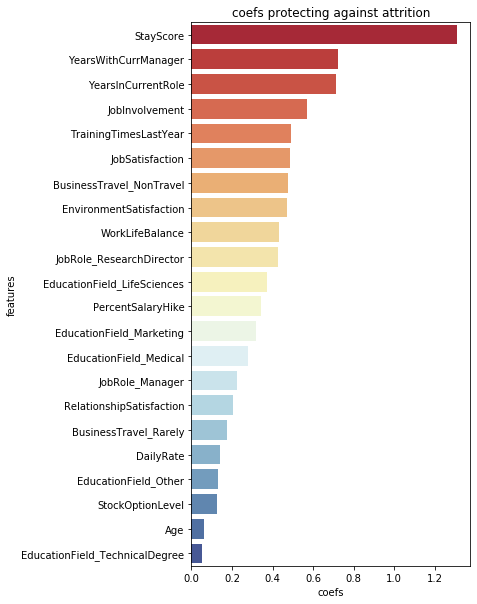

In [98]:
plt.figure(figsize=(5,10))
sb.barplot(lsvc_neg_class.coefs*-1, lsvc_neg_class.features, palette="RdYlBu")
plt.title('coefs protecting against attrition')
plt.show()

In [99]:
from mlxtend.evaluate import feature_importance_permutation

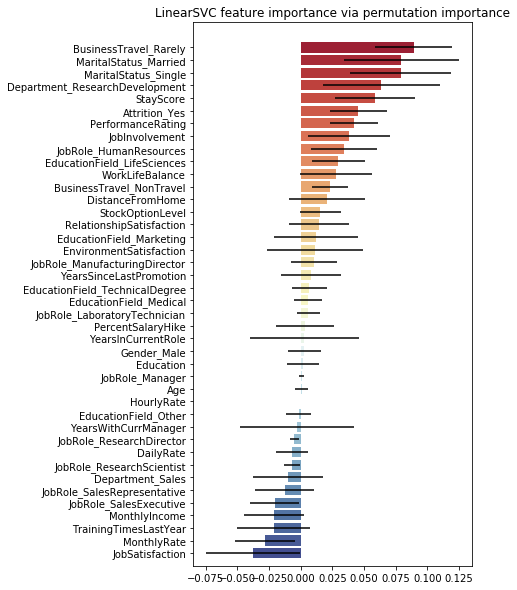

In [100]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_LinearSVC.predict, 
    X=test_features,
    y=test_labels,
    metric=metrics.f1_score,
    num_rounds=100,
    seed=1)

X=test_df
y=test_labels

#imp_vals = minmax.fit_transform(imp_vals.reshape(-1,1)).ravel()

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::1]

plt.figure(figsize=(5,10))
plt.title("LinearSVC feature importance via permutation importance")
sb.barplot(y=test_df.columns[indices], x=imp_vals[indices], xerr=std[indices], palette="RdYlBu_r")
#plt.barh(test_df.columns[indices], imp_vals[indices], xerr=std[indices])
#plt.yticks(range(X.shape[1]), test_df.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.show()

### D.4 Weighted NN

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


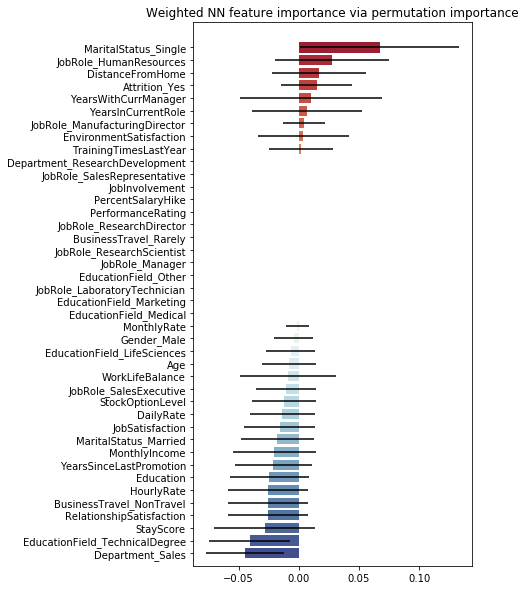

In [101]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_keras_w.predict_classes, 
    X=test_features,
    y=test_labels,
    metric=metrics.f1_score,
    num_rounds=50,
    seed=1)

X=test_df
y=test_labels

#imp_vals = minmax.fit_transform(imp_vals.reshape(-1,1)).ravel()

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::1]

plt.figure(figsize=(5,10))
plt.title("Weighted NN feature importance via permutation importance")
sb.barplot(y=test_df.columns[indices], x=imp_vals[indices], xerr=std[indices], palette="RdYlBu_r")
plt.ylim([-1, X.shape[1]])
plt.show()